In [1]:
import dipy

In [2]:
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs

In [3]:
from fenics import *
from mshr import *
#from math import pi, sin, cos, sqrt
import math
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import os
import subprocess

In [4]:
fname = 'dMRI_data/ms-ras_data.nii.gz' 
bval_fname = 'dMRI_data/ms-ras.bval' 
bvec_fname = 'dMRI_data/ms-ras.bvec'

data, affine = load_nifti(fname)
bvals, bvecs = read_bvals_bvecs(bval_fname, bvec_fname)
dims = data.shape
print('data.shape (%d, %d, %d, %d)' % dims)

data_float = data.astype(np.float32)

dataMaxVal = int(max(data.flatten()))
dataMinVal = int(min(data.flatten()))

print('b values: ', bvals)
print('b vectors: ', bvecs)

data.shape (104, 104, 72, 99)
b values:  [   0.  700.  700.  700.  700.  700.  700.  700.  700.  700.  700.  700.
  700.  700.  700.  700.  700.  700.  700.  700.  700.    0.  700.  700.
  700.  700.  700.  700.  700.  700.  700.  700. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000.    0. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000.    0. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
    0. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000.]
b vectors:  [[ 0.0000000e+00 -0.0000000e+00  0.0000000e+00]
 [ 2.2293058e-01  4.9968055e-01  8.3703119e-01]
 [-1.7871778e-01  4.9333411e-01  8.5128242e-01]
 [-3.7542525e-01  1.4225766e-01  9.1587037e-01]
 [ 4.1157657e-01  7.2193778e-01  5.5624700e-01]
 [ 1.9853516e-01  9.3616748e-01  2.9012811e-01]
 [ 8.4751403e-01  5.2907634e-01  4.2405690e-02]
 [ 7.39

In [5]:
#Input volume number
k = 10

#B vector
b = 2000
b2000_indcs = np.where(bvals==b)
b0_inds = np.where(bvals==0)
b0_ind = b0_inds[0][0]

In [6]:
#To select well distruted (farthes pointing vectors in 3D)
def calc_distances(p0, points):
    return np.minimum(((p0 - points)**2).sum(axis=1), ((-p0 - points)**2).sum(axis=1))
    #return ((p0 - points)**2).sum(axis=1)
    
def farthestPts(pts, K):
    farthest_pts = np.zeros((K, 3))
    pts_inds = np.zeros(K)
    #farthest_pts[0] = pts[np.random.randint(len(pts))]
    farthest_pts[0] = pts[1]
    pts_inds[0] = 1
    distances = calc_distances(farthest_pts[0], pts)
    for i in range(1, K):
        farthest_pts[i] = pts[np.argmax(distances)]
        pts_inds[i] = np.argmax(distances)
        distances = np.minimum(distances, calc_distances(farthest_pts[i], pts))
    return farthest_pts, pts_inds
sub_bvecs, sub_indcs = farthestPts(bvecs[bvals==b], k)
print('b sub vectors: ', sub_bvecs)
#print('b sub vector indecs ', sub_indcs)

#Choose true indeces
true_sub_indcs = np.zeros(len(sub_indcs))
for i in range(len(sub_indcs)):
    true_sub_indcs[i] = b2000_indcs[0][int(sub_indcs[i])]
true_sub_indcs = np.append(true_sub_indcs, b0_ind)
sorted_true_sub_indcs = np.sort(true_sub_indcs)
#print('b sub vectors: ', sub_bvecs)
print('sorted b sub vector indeces ', sorted_true_sub_indcs)

b sub vectors:  [[-4.9948000e-04  9.9898493e-01  4.5043090e-02]
 [-9.9998999e-01 -3.9998800e-03  1.9999400e-03]
 [-2.4582910e-02  1.1101565e-01 -9.9351466e-01]
 [-5.6061244e-01 -6.2922853e-01  5.3831679e-01]
 [-4.5817986e-01 -5.9716052e-01 -6.5838480e-01]
 [-4.5601672e-01  6.9743240e-01 -5.5284446e-01]
 [-4.9492225e-01  6.7110866e-01  5.5196494e-01]
 [ 7.1813208e-01 -1.0619420e-02  6.9582558e-01]
 [ 5.7621109e-01 -7.1084380e-02 -8.1420386e-01]
 [ 7.6881015e-01  6.3443005e-01  8.0182670e-02]]
sorted b sub vector indeces  [ 0. 32. 33. 44. 47. 71. 73. 78. 86. 87. 93.]


In [7]:
# Selecting one b0 and k+7 b700 voxels
sorted_true_sub_indcs = sorted_true_sub_indcs.astype(int)
sub_bvals = bvals[sorted_true_sub_indcs]
print(sub_bvals)

sub_data = data_float[:, :, :, sorted_true_sub_indcs]
print(sub_data.shape)

[   0. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.]
(104, 104, 72, 11)


In [8]:
##Registration
#b0_ind = np.where(sub_bvals==0)[0]
#regis_sub_data = subprocess.run(["eddy_correct", "cosine_weighted_averaging/sub_vols.nii.gz", "cosine_weighted_averaging/registered_data/sub_data_lowb-corrected.nii.gz", str(b0_ind[0])])
#print("The exit code was: %d" % regis_sub_data.returncode)

In [9]:
#Load registrated data
nameStr = 'LH_all_voxels/multi_shell_registerered_data/kFrame_correct10.nii.gz'     
sub_regis_data, sub_regis_affine = load_nifti(nameStr)
dims_sub = sub_regis_data.shape
print('data.shape (%d, %d, %d, %d)' % sub_regis_data.shape)
print('Type: ', sub_regis_data.dtype)

data.shape (104, 104, 72, 11)
Type:  float32


In [10]:
#Volume Index to predict
nextIter_sub_bvecs, nextIter_sub_indcs = farthestPts(bvecs[bvals==b], k+1)
nextIter_true_sub_indcs = np.zeros(len(nextIter_sub_indcs))
for i in range(len(nextIter_sub_indcs)):
    nextIter_true_sub_indcs[i] = b2000_indcs[0][int(nextIter_sub_indcs[i])]
nextIter_true_sub_indcs = np.append(nextIter_true_sub_indcs, b0_ind)
sorted_nextIter_true_sub_indcs = np.sort(nextIter_true_sub_indcs)
print('b sub vector indecs ', sorted_nextIter_true_sub_indcs)
nextIter_sub_indcs = sorted_nextIter_true_sub_indcs.astype(int)
    
inter_sub_indcs = [i for i in sorted_nextIter_true_sub_indcs if i not in sorted_true_sub_indcs]
if len(inter_sub_indcs) != 0: 
    left_indcs = inter_sub_indcs[0]
else:
    left_indcs = np.arange(data.shape[3])
    left_indcs = np.delete(left_indcs, sorted_true_sub_indcs)
    print(left_indcs)
    left_indcs = left_indcs[0]
left_indcs = left_indcs.astype(int)
print("Predicted volume: ", left_indcs)

b sub vector indecs  [ 0. 32. 33. 44. 47. 71. 73. 78. 85. 86. 87. 93.]
Predicted volume:  85


In [11]:
def project_point_onto_affine_subspace(p, V):
    """Projects a point onto an affine subspace

    p.shape = (N,)   OR (num_pts, N) for vectorization over many points / affine subspaces
    V.shape = (k, N) OR (num_pts, k, N) for vectorization

    N = dimension of ambient space
    k-1 = dimension of affine subspace

    For a single point / affine subspace:
        - p is the point in R^N to be projected onto the affine subspace
        - The affine subspace is the set of all affine combinations
        of rows, V[i,:], of the matrix V

    Vectorization:
    For many points / affine subspaces, each point is
    projected onto its corresponding affine subspace
        p[i,:] is the ith point
        V[i,:,:] is the matrix defining the ith affine subspace

    Example usage:
        import numpy as np
        spatial_dim = 3
        p1 = np.random.randn(spatial_dim)
        V1 = np.array([[2., 0., 0.],
                      [2., 1., 0.],
                      [2., 0., 1.]])
        p2 = np.random.randn(spatial_dim)
        V2 = np.array([[0., 3., 0.],
                       [1., 3., 0.],
                       [0., 3., 1.]])
        p = np.stack([p1, p2])
        V = np.stack([V1, V2])
        projected_p, affine_coordinates = project_point_onto_affine_subspace(p, V)
        projected_p1 = projected_p[0,:]
        projected_p2 = projected_p[1,:]
        print('p1=', p1)
        print('projected_p1=', projected_p1)
        print('p2=', p2)
        print('projected_p2=', projected_p2)
    """
    if len(p.shape) == 1:
        PP = p.reshape((1, p.shape[0]))
        VV = V.reshape((1, V.shape[0], V.shape[1]))
    else:
        PP = p
        VV = V
    num_pts, k, N = VV.shape

    if k == 1:
        affine_coordinates = np.ones((num_pts, 1))
    else:
        VV0 = VV[:, 0, :].reshape((num_pts, 1, N))
        dVV = VV[:, 1: :].reshape((num_pts, k-1, N)) - VV0
        dPP = PP.reshape((num_pts, 1, N)) - VV0

        if k == 2:
            PHI = np.sum(dVV * dVV, axis=-1).reshape((num_pts))
            RHS = np.sum(dVV * dPP, axis=-1).reshape((num_pts))
            cc_rest = (RHS / PHI).reshape((num_pts, 1))
        else:
            PHI = np.einsum('xiz,xjz->xij', dVV, dVV) # shape = (num_pts, k-1, k-1)
            iPHI = np.linalg.inv(PHI) # shape = (num_pts, k-1, k-1)

            RHS = np.sum(dVV * dPP, axis=-1)  # shape = (num_pts, k-1)
            cc_rest = np.einsum('pij,pj->pi', iPHI, RHS)  # shape = (num_pts, k-1)

        cc_first = (1. - np.sum(cc_rest, axis=1)).reshape((num_pts, 1))
        affine_coordinates = np.concatenate([cc_first, cc_rest], axis=1) # shape = (num_pts, k)

    PP_projected = np.einsum('pi,pij->pj', affine_coordinates, VV) # shape = (num_pts, N)

    if len(p.shape) == 1:
        PP_projected = PP_projected.reshape(-1)
        affine_coordinates = affine_coordinates.reshape(-1)
    return PP_projected, affine_coordinates

def powerset(s):
    # NOT MY CODE. FROM USER "hughdbrown" ON STACKOVERFLOW HERE:
    # https://stackoverflow.com/a/1482320/484944
    x = len(s)
    masks = [1 << i for i in range(x)]
    for i in range(1 << x):
        yield [ss for mask, ss in zip(masks, s) if i & mask]

def closest_point_on_simplex(p, V):
    """Projects a point onto a simplex (triangle, tetrahedron, etc)

    p.shape = (N,)   OR (num_pts, N) for vectorization over many points/simplices
    V.shape = (k, N) OR (num_pts, k, N) for vectorization

    N = dimension of ambient space
    k-1 = dimension of simplex

    For a single point/simplex:
        - p is the point in R^N to be projected onto the simplex
        - The simplex is the set of all convex combinations
        of rows, V[i,:], of the matrix V

    Vectorization:
    For many points/simplices, each point is
    projected onto its corresponding simplex
        p[i,:] is the ith point
        V[i,:,:] is the matrix defining the ith simplex

    Example usage:
        import numpy as np
        import matplotlib.pyplot as plt
        p1 = np.array([1.1, 0.4])
        V1 = np.array([[0., 0.],
                       [0., 1.],
                       [1., 0.]])
        p2 = np.array([-0.3, 1.1])
        V2 = np.array([[-1.0, 0.],
                       [0.,   0.],
                       [-0.5, 0.5]])
        p = np.stack([p1, p2])
        V = np.stack([V1, V2])
        projected_p = closest_point_on_simplex(p, V)
        projected_p1 = projected_p[0,:]
        projected_p2 = projected_p[1,:]
        plt.figure()
        t1 = plt.Polygon(V1)
        plt.gca().add_patch(t1)
        plt.plot([p1[0], projected_p1[0]],
                 [p1[1], projected_p1[1]], 'r')
        t2 = plt.Polygon(V2)
        plt.gca().add_patch(t2)
        plt.plot([p2[0], projected_p2[0]],
                 [p2[1], projected_p2[1]], 'r')
        plt.gca().set_aspect('equal')
        plt.show()
    """
    if len(p.shape) == 1:
        PP = p.reshape((1, p.shape[0]))
        VV = V.reshape((1, V.shape[0], V.shape[1]))
    else:
        PP = p
        VV = V
    num_pts, k, N = VV.shape

    subsets = list(powerset(list(range(k)))) # e.g., [[], [0], [1], [2], [0,1], [0,2], [1,2], [0,1,2]]
    QQ = list()
    CC = list()
    for s in subsets:
        if s:
            simplicial_facet = VV[:,s,:]
            Q, C = project_point_onto_affine_subspace(PP, simplicial_facet)
            QQ.append(Q)
            CC.append(C)

    distances = np.stack([np.linalg.norm(Q - PP, axis=-1) for Q in QQ]) # shape=(num_facets, num_pts)

    good_inds = np.stack([(np.all(0. <= C, axis=1) & np.all(C <= 1., axis=1)) for C in CC]) # shape=(num_facets, num_pts)
    bad_inds = np.logical_not(good_inds)
    distances[bad_inds] = np.inf
    closest_inds = np.expand_dims(np.argmin(distances[:, :, None], axis=0), axis=0)

    QQ_stack = np.stack(QQ) # shape=(num_facets, num_pts, N)
    PP_projected = np.take_along_axis(QQ_stack, closest_inds, axis=0)[0,:,:]

    if len(p.shape) == 1:
        PP_projected = PP_projected.reshape(-1)
    return PP_projected

def closest_point_in_mesh(p, mesh):
    """Finds the nearest point in a mesh to a given point
    p is the point or points (numpy array)
    mesh is the fenics/dolfin mesh

    p.shape = (N,) OR (num_pts, N) for vectorization over many points
    N = dimension of ambient space

    Example usage:
        import numpy as np
        import dolfin as dl
        import matplotlib.pyplot as plt
        mesh = dl.UnitSquareMesh(13,9)
        num_pts = 20
        p = np.random.randn(num_pts, 2) + np.array([0.5, 0.5])
        closest_p = closest_point_in_mesh(p, mesh)
        plt.figure()
        dl.plot(mesh)
        for ii in range(num_pts):
            plt.plot([p[ii,0], closest_p[ii,0]], [p[ii,1], closest_p[ii,1]], 'b')
            plt.plot(p[ii,0], p[ii,1], '*k')
            plt.plot(closest_p[ii,0], closest_p[ii,1], '.r')
        plt.show()
    """
    if len(p.shape) == 1:
        PP = p[None,:]
    else:
        PP = p
    num_pts, N = PP.shape
    tdim = mesh.topology().dim()
    k = tdim + 1

    VV = np.zeros((num_pts, k, N))
    bbt = mesh.bounding_box_tree()
    for ii in range(num_pts):
        pi = PP[ii,:]
        closest_entity, closest_distance = bbt.compute_closest_entity(Point(pi))
        closest_cell = mesh.cells()[closest_entity]
        vertices_of_closest_cell = mesh.coordinates()[closest_cell, :]
        VV[ii, :, :] = vertices_of_closest_cell

    closest_PP = closest_point_on_simplex(PP, VV)

    if len(p.shape) == 1:
        closest_PP = closest_PP.reshape(-1)
    return closest_PP

In [12]:
#center = Point(0.0, 0.0, 0.0)
#sphere = Sphere(center,1.0)
#mesh = generate_mesh(sphere,5) # 20 specify the resolution of the mesh
#plot(mesh)

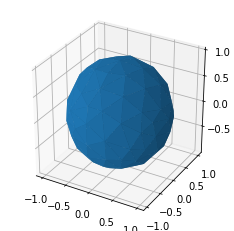

In [13]:
# Mesh and function space
#sphere = Sphere(Point(0.0, 0.0, 0.0), 1.0)
#vmesh = generate_mesh(sphere, 5)
#mesh = BoundaryMesh(vmesh, "exterior")
#plot(mesh)

mesh = Mesh('LH/mesh_whole_sphere.xml')
plot(mesh)

In [14]:
for ind in nextIter_sub_indcs:
    print(ind)

0
32
33
44
47
71
73
78
85
86
87
93


In [15]:
for ind in sorted_true_sub_indcs:
    print(ind)

0
32
33
44
47
71
73
78
86
87
93


In [16]:
left_indcs

85

In [17]:
np.array_equal(sub_data[...,8], data_float[...,86])

True

In [18]:
inpaintedImg_3D = np.zeros((dims[0], dims[1], dims[2]))
bvec_volPredict = bvecs[left_indcs]
for i in range(dims[0]):
    print("IIIIIIIIIIII: ", i)
    for j in range(dims[1]):
        for k in range(dims[2]):
            #V = FunctionSpace(mesh, "CG", 2)
            V = FunctionSpace(mesh, "P", 1)

            # get coordinates of DOFs
            dof_coords = V.tabulate_dof_coordinates()
            
            bcs = []
            cnt = 0
            for ind in sorted_true_sub_indcs:
                if ind!=0:
                    # find nearest DOF:
                    dof = np.argmin(np.linalg.norm(dof_coords - bvecs[ind], axis=1))
                    #print('dof {}, x = {}'.format(dof, dof_coords[dof]))
                    dof_sym = np.argmin(np.linalg.norm(dof_coords + bvecs[ind], axis=1))
                    #print('dof {}, x = {}'.format(dof_sym, dof_coords[dof_sym])) 
            
                    # now define a DirichletBC at that point
                    bcs.extend([DirichletBC(V, Constant(sub_regis_data[i,j,k,cnt]),
                                     'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof][0], y=dof_coords[dof][1], z=dof_coords[dof][2]),
                                     'pointwise'),
                                DirichletBC(V, Constant(sub_regis_data[i,j,k,cnt]),
                                     'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof_sym][0], y=dof_coords[dof_sym][1], z=dof_coords[dof_sym][2]),
                                     'pointwise')])
                #print(ind, cnt)
                cnt = cnt+1
            
            u = TrialFunction(V) 
            v = TestFunction(V)
            w = Function(V)      

            #x = SpatialCoordinate(mesh)
            # Defining spherical coordinates
            #phi = Expression("atan2(x[1],x[0])", degree=2)
            #theta = Expression("acos(x[2]/sqrt(x[0]*x[0]+x[1]*x[1]+x[2]*x[2]))", degree=2)
            
            #a2 = u.dx(1)*v.dx(1)
            #a3 = (Constant(1.)/sin(theta)**2)*(u.dx(2)*v.dx(2))
            #a4 = (cos(theta)/sin(theta))*u.dx(1)*v
            #a = (a2+a3-a4)*dx
            
            a=inner(grad(u),grad(v))*dx
    
            #a1 = (sin(theta)*sin(theta)*sin(phi)*sin(phi)+cos(theta)*cos(phi)/sin(theta))*(u.dx(0)*v.dx(0))
            #a2 = (cos(theta)*cos(theta)*sin(phi)*sin(phi)+cos(phi)*cos(phi))*(u.dx(1)*v.dx(1))
            #a3 = (sin(phi)**2/sin(theta)**2)*(u.dx(2)*v.dx(2))
            #a4 = (-sin(theta)*sin(phi)*sin(phi)*cos(theta)+cos(theta)*cos(phi)*cos(phi)*sin(theta))*(u.dx(0)*v.dx(1))
            #a5 = (-cos(theta)*cos(phi)*sin(phi))*(u.dx(0)*v.dx(2))
            #a6 = (-cos(theta)*sin(phi)*sin(phi))*(u.dx(1)*v.dx(2))
            #a7 = (cos(theta)*sin(phi))*(u.dx(0)*v)
            #a8 = (-cos(theta)*cos(theta)*sin(phi)/sin(theta))*(u.dx(1)*v)
            #a = (a1+a2+a3+a4+a5+a6+a7+a8)*dx
    
            f = Constant(0.0)

            L = f*v*dx
            solve(a == L, w, bcs)
    
            # Save solution to file in VTK format
            #vtkfile = File('LH_all_voxels/solution_' + str(i) + '_' + str(j) + '_' + str(k) + '.pvd')
            #vtkfile << w
            
            #Volume Prediction
            closest_p = closest_point_in_mesh(bvec_volPredict, mesh)
            #print(bvecs[27])
            #print(closest_p)
            #print(w(closest_p))
            
            inpaintedImg_3D[i,j,k] = w(closest_p)

IIIIIIIIIIII:  0
IIIIIIIIIIII:  1
IIIIIIIIIIII:  2
IIIIIIIIIIII:  3
IIIIIIIIIIII:  4
IIIIIIIIIIII:  5
IIIIIIIIIIII:  6
IIIIIIIIIIII:  7
IIIIIIIIIIII:  8
IIIIIIIIIIII:  9
IIIIIIIIIIII:  10
IIIIIIIIIIII:  11
IIIIIIIIIIII:  12
IIIIIIIIIIII:  13
IIIIIIIIIIII:  14
IIIIIIIIIIII:  15
IIIIIIIIIIII:  16
IIIIIIIIIIII:  17
IIIIIIIIIIII:  18
IIIIIIIIIIII:  19
IIIIIIIIIIII:  20
IIIIIIIIIIII:  21
IIIIIIIIIIII:  22
IIIIIIIIIIII:  23
IIIIIIIIIIII:  24
IIIIIIIIIIII:  25
IIIIIIIIIIII:  26
IIIIIIIIIIII:  27
IIIIIIIIIIII:  28
IIIIIIIIIIII:  29
IIIIIIIIIIII:  30
IIIIIIIIIIII:  31
IIIIIIIIIIII:  32
IIIIIIIIIIII:  33
IIIIIIIIIIII:  34
IIIIIIIIIIII:  35
IIIIIIIIIIII:  36
IIIIIIIIIIII:  37
IIIIIIIIIIII:  38
IIIIIIIIIIII:  39
IIIIIIIIIIII:  40
IIIIIIIIIIII:  41
IIIIIIIIIIII:  42
IIIIIIIIIIII:  43
IIIIIIIIIIII:  44
IIIIIIIIIIII:  45
IIIIIIIIIIII:  46
IIIIIIIIIIII:  47
IIIIIIIIIIII:  48
IIIIIIIIIIII:  49
IIIIIIIIIIII:  50
IIIIIIIIIIII:  51
IIIIIIIIIIII:  52
IIIIIIIIIIII:  53
IIIIIIIIIIII:  54
IIIIIIIIIIII:  55
II

In [19]:
ni_img = nib.Nifti1Image(inpaintedImg_3D, affine=affine)
nib.save(ni_img, "multi_qspace_LH_volume_image_whole_sphere_85_corrected_new.nii")

In [20]:
array_u = nodal_values_u = w.vector()
vertex_values_u = w.compute_vertex_values()

In [21]:
print(array_u)

In [22]:
for i in range(len(array_u)):
    print(array_u[i])

0.10261058205234541
0.2204317085179821
0.14222997751472147
0.0
0.1655257374659635
0.0
0.28816009820838173
0.0
0.26624195026749803
0.2224013169154641
0.18912703913854434
0.23618392268350974
0.28357392042458823
0.23210862669338617
0.16206767071754113
0.3896861101021873
0.3110847236261589
0.24124197680280104
0.15192670766651103
0.16249865053569904
0.26115103189972605
0.2506345609552876
0.17936339530066323
0.16400645271197828
0.45769789814949036
0.285055927762205
0.45081260800361633
0.24970076762353247
0.22899143531753918
0.25818917740970415
0.5525735168620268
0.41652240329899776
0.287039336114014
0.25724591962541327
0.26262336630896566
0.22194689244664362
0.27743296228577363
0.2777657392538999
0.33406715631518313
0.20986854811979264
0.2013308062892803
0.0
0.3726190181684386
0.8818130493164062
0.489639620506792
0.3245362983900145
0.0
0.1845002840020362
0.31869963555035846
0.30823220006652713
0.2721858511496661
0.3228867382678323
0.33135989638339014
0.2792597007990471
0.24230783880624332
0.

In [23]:
min(array_u)

0.0

In [24]:
len(array_u)

118

In [25]:
bvecs[1][0]

0.22293058

In [26]:
bvecs[1][2]

0.83703119

In [27]:
data_float[63,54,30,1]

43.0

In [28]:
data_float[63,54,30,14]

46.0

In [29]:
data_float[63,54,30,17]

13.0

In [30]:
data_float[63,54,30,20]

48.0

In [31]:
data_float[63,54,30,22]

25.0

In [32]:
data_float[63,54,30,29]

52.0

In [33]:
#error_L2 = errornorm(u_D, w, 'L2')
#vertex_values_u_D = u_D.compute_vertex_values(mesh)
#vertex_values_u = w.compute_vertex_values(mesh)
#error_max = np.max(np.abs(vertex_values_u_D - vertex_values_u))
#print(error_max)
#print(error_L2)

In [34]:
bvecs[27]

array([-0.70739847,  0.15345097,  0.68995672])

In [35]:
x_point = Point(*[bvecs[27]])
mesh.bounding_box_tree().compute_first_entity_collision(x_point)

4294967295

In [36]:
#mesh.bounding_box_tree().compute_closest_point(x_point)

In [37]:
inpaintedImg_3D.shape

(104, 104, 72)

In [38]:
max(inpaintedImg_3D.flatten())

136.15950275609782